<a href="https://colab.research.google.com/github/nulven/PrivacyML/blob/master/FInal_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%cd '/content/drive/MyDrive/final/MNIST'

/content/drive/MyDrive/final/MNIST


In [ ]:
import numpy as np 
import matplotlib.pyplot as plt
import copy

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingLR, CosineAnnealingWarmRestarts
import torchvision
import torchvision.transforms as tt
import torchvision.models as models
from torchvision.datasets import MNIST, CIFAR10, ImageFolder
from torchvision.utils import make_grid
from torch.utils.data import random_split, DataLoader, Subset
from torch.nn.utils import vector_to_parameters, parameters_to_vector

from sklearn.metrics import accuracy_score

import os
import time
import pickle

torch.manual_seed(0)
np.random.seed(0)

In [1]:
pip install kaggle

In [5]:
python -m

SyntaxError: ignored

In [ ]:
transform = tt.Compose([tt.ToTensor(),
                    tt.Normalize((0.1307,), (0.3081,))])

train_ds = MNIST(root='.', train=True, download=True, transform=transform)
test_ds = MNIST(root='.', train=False, download=True, transform=transform)

In [ ]:
batch_size=100

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers = 4, pin_memory=True)
test_dl = DataLoader(test_ds, batch_size, num_workers = 4, pin_memory=True)

In [ ]:
kaggle datasets download -d kinguistics/heartbeat-sounds

In [ ]:
device = 'cuda' if torch.cuda.is_available else 'cpu'
device

'cuda'

In [ ]:
class MnistNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(1, 10, 5),
                                   nn.MaxPool2d(2),
                                   nn.ReLU())
        self.conv2 = nn.Sequential(nn.Conv2d(10, 20, kernel_size=5),
                                   nn.Dropout2d(),
                                   nn.MaxPool2d(2),
                                   nn.ReLU())
        self.fc1 = nn.Sequential(nn.Flatten(),
                                 nn.Linear(320, 50),
                                 nn.Dropout(),
                                 nn.ReLU())
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.fc1(x)
        x = self.fc2(x)
        return x

In [ ]:
def train(model, train_dl, optimizer, criterion):
    model.to(device)
    model.train()
    batch_loss, batch_acc = [], []
    for images, labels in train_dl:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        logits = model(images)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        batch_loss.append(loss.detach().cpu())
        pred = torch.argmax(logits, dim=1)
        batch_acc.append(accuracy_score(labels.cpu(), pred.cpu()))
    model.cpu()
    return sum(batch_loss)/len(batch_loss), sum(batch_acc)/len(batch_acc)

In [ ]:
def test(model, test_dl, criterion):      
    with torch.no_grad():
        model.to(device)
        model.eval()
        batch_loss, batch_acc = [], []
        for images, labels in test_dl:
            images, labels = images.to(device), labels.to(device)
            logits = model(images)
            loss = criterion(logits, labels)
            batch_loss.append(loss.cpu())
            pred = torch.argmax(logits, dim=1)
            batch_acc.append(accuracy_score(labels.cpu(), pred.cpu()))
        model.cpu()
        return sum(batch_loss)/len(batch_loss), sum(batch_acc)/len(batch_acc)

In [ ]:
def fit(epochs, model, optimizer,criterion, train_dl, test_dl):
    train_loss, train_acc, test_loss, test_acc = [], [], [], []
    for epoch in range(1,epochs+1):
        trainl, traina = train(model, train_dl, optimizer, criterion)
        testl , testa = test(model, test_dl, criterion)
        train_loss.append(trainl)
        train_acc.append(traina)
        test_loss.append(testl)
        test_acc.append(testa)
        print(f'Epoch {epoch} - train_loss : {trainl :.4f}, train_acc : {traina:.4f}, test_loss : {testl:.4f}, test_acc : {testa:0.4f}')

    history = {'train_loss' : train_loss,
               'train_acc' : train_acc,
               'test_loss' : test_loss,
               'test_acc' : test_acc}
    return history

In [ ]:
def plot(epochs, title, history):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
    t = f.suptitle(title, fontsize=24)
    f.patch.set_facecolor('white')
    f.subplots_adjust(top=0.85, wspace=0.3)
    epoch_list = list(range(1,epochs+1))

    ax1.plot(epoch_list, history['train_acc'], label='Train Accuracy')
    ax1.plot(epoch_list, history['test_acc'], label='Test Accuracy')
    ax1.set_ylabel('Accuracy Value')
    ax1.set_xlabel('Epoch')
    ax1.set_title('Accuracy', fontsize = 18)
    ax1.grid(True)
    l1 = ax1.legend(loc="best")

    ax2.plot(epoch_list, history['train_loss'], label='Train Loss')
    ax2.plot(epoch_list, history['test_loss'], label='Test Loss')
    ax2.set_ylabel('Loss Value')
    ax2.set_xlabel('Epoch')
    ax2.set_title('Loss', fontsize = 18)
    ax2.grid(True)
    l2 = ax2.legend(loc="best")
    return f

In [ ]:
def save(history, model, figure, name):
    with open(name + '.pickle', 'wb') as handle:
        pickle.dump(history, handle)
    torch.save(model, name + '.pth')
    figure.savefig(name + '.png')

In [ ]:
def make_iid_dls(train_ds, n):
    size = len(train_ds)//n
    last_size = size + len(train_ds)%n
    client_ds = random_split(train_ds, [size]*(n-1) + [last_size])
    client_dls = [DataLoader(ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)for ds in client_ds]
    return client_dls

In [ ]:
def make_noniid_dls(train_ds, n):
    num_shards, num_imgs = 2*n, len(train_ds)//(2*n)
    idx_shard = [i for i in range(num_shards)]
    dict_clients = {i: np.array([]) for i in range(n)}
    idxs = np.arange(num_shards*num_imgs)
    labels = train_ds.targets

    # sort labels
    idxs_labels = np.vstack((idxs, labels[:len(idxs)]))
    idxs_labels = idxs_labels[:,idxs_labels[1,:].argsort()]
    idxs = idxs_labels[0,:]

    # divide and assign
    for i in range(n):
        rand_set = set(np.random.choice(idx_shard, 2, replace=False))
        idx_shard = list(set(idx_shard) - rand_set)
        for rand in rand_set:
            dict_clients[i] = np.concatenate((dict_clients[i], idxs[rand*num_imgs:(rand+1)*num_imgs]), axis=0)

    client_dls = []
    for i in range(n):
        ds = Subset(train_ds, torch.LongTensor(dict_clients[i]))
        client_dls.append(DataLoader(ds, batch_size, shuffle = True, num_workers = 4, pin_memory = True))
    return client_dls

In [ ]:
torch.manual_seed(0)
np.random.seed(0)
n = 10
iid_dls = make_iid_dls(train_ds, n)
noniid_dls = make_noniid_dls(train_ds, n)

In [ ]:
def make_clients(n):
    models = [MnistNet() for _ in range(n)]
    optimizers = [SGD(model.parameters(), lr=1e-2, momentum=0.9) for model in models]
    return models, optimizers

In [ ]:
def train_clients(client_models, client_optimizers, server_model, criterion, client_dls):
    client_loss, client_acc = [], []
    for model, optimizer, train_dl in zip(client_models, client_optimizers, client_dls):
        model.load_state_dict(server_model.state_dict())T
        closs, cacc = train(model, train_dl, optimizer, criterion)
        client_loss.append(closs)
        client_acc.append(cacc)
    return sum(client_loss)/len(client_loss), sum(client_acc)/len(client_acc)

In [ ]:
def compute_gradient(client_models, server_model, r, compression,sparsity, warmup, epoch):
    n = len(client_models)
    server_dict = server_model.state_dict()
    grad_dict = {k : torch.zeros_like(v) for k, v in server_dict.items()}
    if compression is None:
        for model in client_models:
            client_dict =  model.state_dict()
            for name in client_dict:
                grad_dict[name] += client_dict[name]
        grad_dict = {k : v/n-server_dict[k] for k,v in grad_dict.items()}
    else:
        if epoch <= warmup:
            scale = (sparsity/(1-1/n))**(1/warmup) if compression == 'rTopk' else (sparsity/0.00001)**(1/warmup)
            sparsity /= scale**(warmup-epoch+1)
        grad_vector = nn.utils.parameters_to_vector(grad_dict.values())
        count_vector = copy.deepcopy(grad_vector)
        for i, model in enumerate(client_models):
            client_dict =  model.state_dict()
            residual_dict = r[i]
            g = {k : client_dict[k] - server_dict[k] + residual_dict[k] for k in client_dict}
            g_vector = nn.utils.parameters_to_vector(g.values())
            if compression == "rTopk":
                _, rtop_idx = torch.topk(g_vector.abs(), int((1-sparsity)* len(g_vector))*n, sorted = False)
                topk_idx = np.random.choice(rtop_idx, len(rtop_idx)//n, replace = False)
            else:
                _, topk_idx = torch.topk(g_vector.abs(), int((1-sparsity)* len(g_vector)), sorted = False)
            residual_vector = copy.deepcopy(g_vector)
            residual_vector[topk_idx] = 0
            nn.utils.vector_to_parameters(residual_vector, residual_dict.values())
            grad_vector[topk_idx] += g_vector[topk_idx]
            count_vector[topk_idx] += 1
        count_vector[count_vector == 0] = 1
        grad_vector /= count_vector
        nn.utils.vector_to_parameters(grad_vector, grad_dict.values())
    return grad_dict

In [ ]:
def train_server(model, opt, lr, g, m, v, beta1, beta2, epsilon, epoch, demon, total_epochs):
    s_dict = model.state_dict()
    if opt == 'sgd':
        new_s_dict = {k : s_dict[k] + lr * g[k] for k in s_dict}
    else:
        if demon:
            p = (1-epoch/total_epochs) 
            beta1 *= p/(1-beta1 + beta1*p)
            m = {k : beta1*m[k] + g[k] for k in g}
        else:
            m = {k : beta1*m[k] + (1-beta1)*g[k] for k in g}
        if opt == 'adagrad':
            v =  {k : v[k] + g[k]**2 for k in v}
        if opt == 'yogi':
            v = {k : v[k] - (1-beta2)*torch.sign(v[k] - g[k]**2)*(g[k]**2) for k in v}
        if opt == 'adam':
            v = {k : beta2*v[k] + (1-beta2)*(g[k]**2) for k in v}
        lr *= ((1-beta2**epoch)**0.5)/(1-beta1**epoch)
        new_s_dict = {k : s_dict[k] + lr * m[k]/(v[k]**0.5 + epsilon) for k in s_dict}
    model.load_state_dict(new_s_dict)
    return m, v

In [ ]:
def fit_federated(epochs, client_models, client_optimizers, client_dls, 
                  server_model, server_opt, server_lr, test_dl, criterion,
                  beta1 = 0, beta2 = 0, epsilon = 1e-8, demon = False, compression = None, sparsity = 0, warmup = 5):
    s_dict = server_model.state_dict()
    m = {k : torch.zeros_like(v) for k, v in s_dict.items()}
    v = copy.deepcopy(m)
    r = [copy.deepcopy(m) for _ in range(len(client_models))]
    train_loss, train_acc, test_loss, test_acc = [], [], [], []
    for epoch in range(1,epochs+1):
        trainl, traina = train_clients(client_models, client_optimizers, server_model, criterion, client_dls)
        g = compute_gradient(client_models, server_model, r, compression, sparsity, warmup, epoch)
        m, v = train_server(server_model, server_opt, server_lr, g, m, v, beta1, beta2, epsilon, epoch, demon, epochs)
        testl , testa = test(server_model, test_dl, criterion)
        train_loss.append(trainl)
        train_acc.append(traina)
        test_loss.append(testl)
        test_acc.append(testa)
        print(f'Epoch {epoch} - train_loss : {trainl :.4f}, train_acc : {traina:.4f}, test_loss : {testl:.4f}, test_acc : {testa:0.4f}')

    history = {'train_loss' : train_loss,
               'train_acc' : train_acc,
               'test_loss' : test_loss,
               'test_acc' : test_acc}
    return history

In [ ]:
epochs = 250
criterion = nn.CrossEntropyLoss()

In [ ]:
client_models, client_optimizers = make_clients(n)
server_model = MnistNet()
server_opt = 'sgd'
server_lr = 1

In [ ]:
iid_sgd_history = fit_federated(epochs, client_models, client_optimizers, iid_dls, 
                                server_model, server_opt, server_lr, test_dl, criterion)

Epoch 1 - train_loss : 2.0288, train_acc : 0.2768, test_loss : 0.8810, test_acc : 0.8138
Epoch 2 - train_loss : 0.9160, train_acc : 0.7021, test_loss : 0.3228, test_acc : 0.9202
Epoch 3 - train_loss : 0.6189, train_acc : 0.8075, test_loss : 0.2209, test_acc : 0.9390
Epoch 4 - train_loss : 0.5029, train_acc : 0.8453, test_loss : 0.1773, test_acc : 0.9503
Epoch 5 - train_loss : 0.4410, train_acc : 0.8666, test_loss : 0.1494, test_acc : 0.9563
Epoch 6 - train_loss : 0.3928, train_acc : 0.8814, test_loss : 0.1301, test_acc : 0.9628
Epoch 7 - train_loss : 0.3586, train_acc : 0.8925, test_loss : 0.1201, test_acc : 0.9635
Epoch 8 - train_loss : 0.3351, train_acc : 0.9013, test_loss : 0.1089, test_acc : 0.9668
Epoch 9 - train_loss : 0.3177, train_acc : 0.9066, test_loss : 0.1017, test_acc : 0.9692
Epoch 10 - train_loss : 0.2964, train_acc : 0.9130, test_loss : 0.0949, test_acc : 0.9712
Epoch 11 - train_loss : 0.2811, train_acc : 0.9172, test_loss : 0.0897, test_acc : 0.9727
Epoch 12 - train_lo

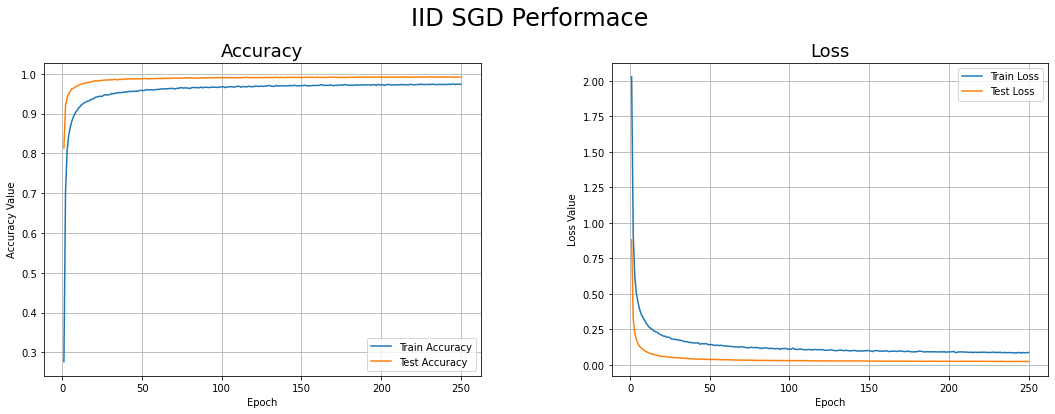

In [ ]:
f = plot(epochs, "IID SGD Performace", iid_sgd_history)

In [ ]:
save(iid_sgd_history, server_model, f, "IID_SGD")

In [ ]:
client_models, client_optimizers = make_clients(n)
server_model = MnistNet()

In [ ]:
noniid_sgd_history = fit_federated(epochs, client_models, client_optimizers, noniid_dls, 
                                server_model, server_opt, server_lr, test_dl, criterion)

Epoch 1 - train_loss : 0.6029, train_acc : 0.7845, test_loss : 2.0877, test_acc : 0.3766
Epoch 2 - train_loss : 0.3101, train_acc : 0.9039, test_loss : 1.4854, test_acc : 0.6032
Epoch 3 - train_loss : 0.2322, train_acc : 0.9320, test_loss : 1.1135, test_acc : 0.6523
Epoch 4 - train_loss : 0.1822, train_acc : 0.9462, test_loss : 0.8393, test_acc : 0.7553
Epoch 5 - train_loss : 0.1572, train_acc : 0.9557, test_loss : 0.6756, test_acc : 0.8083
Epoch 6 - train_loss : 0.1452, train_acc : 0.9589, test_loss : 0.5510, test_acc : 0.8518
Epoch 7 - train_loss : 0.1271, train_acc : 0.9645, test_loss : 0.4697, test_acc : 0.8679
Epoch 8 - train_loss : 0.1203, train_acc : 0.9660, test_loss : 0.4104, test_acc : 0.8859
Epoch 9 - train_loss : 0.1109, train_acc : 0.9693, test_loss : 0.3485, test_acc : 0.9080
Epoch 10 - train_loss : 0.1049, train_acc : 0.9718, test_loss : 0.3281, test_acc : 0.9100
Epoch 11 - train_loss : 0.0981, train_acc : 0.9727, test_loss : 0.2921, test_acc : 0.9233
Epoch 12 - train_lo

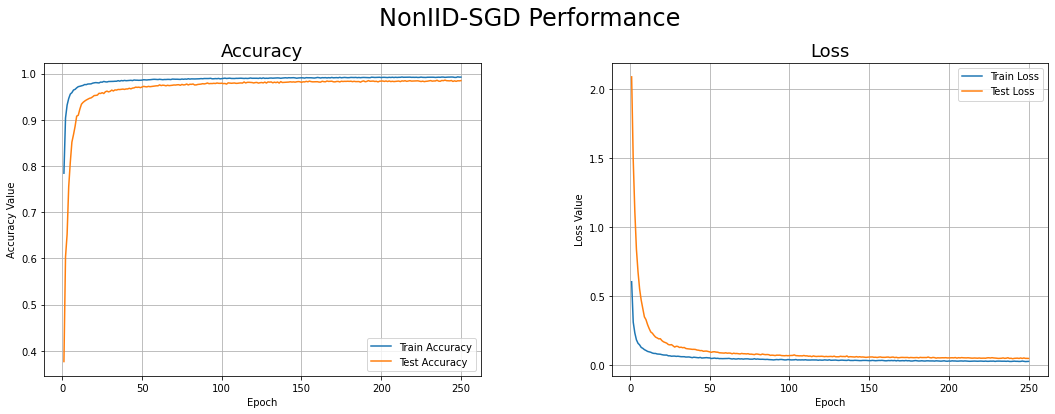

In [ ]:
f = plot(epochs, "NonIID-SGD Performance", noniid_sgd_history)

In [ ]:
save(noniid_sgd_history, server_model, f, "NonIID_SGD")

In [ ]:
client_models, client_optimizers = make_clients(n)
server_model = MnistNet()
server_opt = 'adam'
server_lr = 0.003
beta1 = 0.9
beta2 = 0.999
epsilon = 1e-8
demon = True

In [ ]:
noniid_demon_adam_history = fit_federated(epochs, client_models, client_optimizers, noniid_dls, 
                  server_model, server_opt, server_lr, test_dl, criterion,
                  beta1, beta2, epsilon, demon)

Epoch 1 - train_loss : 0.6313, train_acc : 0.7675, test_loss : 4.3833, test_acc : 0.3058
Epoch 2 - train_loss : 0.3649, train_acc : 0.9162, test_loss : 1.3799, test_acc : 0.5610
Epoch 3 - train_loss : 0.2440, train_acc : 0.9311, test_loss : 0.9075, test_acc : 0.7320
Epoch 4 - train_loss : 0.2174, train_acc : 0.9407, test_loss : 0.5839, test_acc : 0.8044
Epoch 5 - train_loss : 0.1761, train_acc : 0.9516, test_loss : 0.4115, test_acc : 0.8791
Epoch 6 - train_loss : 0.1559, train_acc : 0.9588, test_loss : 0.3454, test_acc : 0.8979
Epoch 7 - train_loss : 0.1407, train_acc : 0.9613, test_loss : 0.3145, test_acc : 0.8996
Epoch 8 - train_loss : 0.1315, train_acc : 0.9643, test_loss : 0.2833, test_acc : 0.9164
Epoch 9 - train_loss : 0.1307, train_acc : 0.9650, test_loss : 0.2662, test_acc : 0.9289
Epoch 10 - train_loss : 0.1226, train_acc : 0.9671, test_loss : 0.2630, test_acc : 0.9332
Epoch 11 - train_loss : 0.1161, train_acc : 0.9694, test_loss : 0.2599, test_acc : 0.9301
Epoch 12 - train_lo

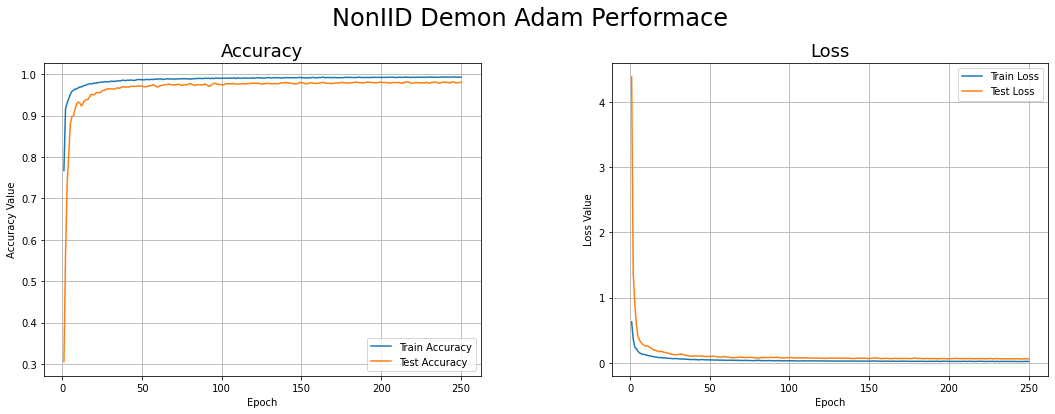

In [ ]:
f = plot(epochs, "NonIID Demon Adam Performace", noniid_demon_adam_history)

In [ ]:
save(noniid_demon_adam_history, server_model, f, "NonIID_Demon_Adam")

In [ ]:
client_models, client_optimizers = make_clients(n)
server_model = MnistNet()
compression = 'rTopk'
server_lr = 0.001
sparsity = 0.99
warmup = 5

In [ ]:
noniid_demon_adam_rtopk_history = fit_federated(epochs, client_models, client_optimizers, noniid_dls, 
                  server_model, server_opt, server_lr, test_dl, criterion,
                  beta1, beta2 , epsilon , demon , compression , sparsity , warmup)

Epoch 1 - train_loss : 0.6088, train_acc : 0.7874, test_loss : 2.2865, test_acc : 0.1436
Epoch 2 - train_loss : 0.5189, train_acc : 0.8272, test_loss : 2.2630, test_acc : 0.1504
Epoch 3 - train_loss : 0.4876, train_acc : 0.8391, test_loss : 2.2311, test_acc : 0.1906
Epoch 4 - train_loss : 0.4471, train_acc : 0.8582, test_loss : 2.1912, test_acc : 0.2593
Epoch 5 - train_loss : 0.4115, train_acc : 0.8715, test_loss : 2.1440, test_acc : 0.3734
Epoch 6 - train_loss : 0.3795, train_acc : 0.8830, test_loss : 2.0921, test_acc : 0.4471
Epoch 7 - train_loss : 0.3566, train_acc : 0.8897, test_loss : 2.0370, test_acc : 0.4680
Epoch 8 - train_loss : 0.3305, train_acc : 0.8997, test_loss : 1.9804, test_acc : 0.4690
Epoch 9 - train_loss : 0.3091, train_acc : 0.9062, test_loss : 1.9232, test_acc : 0.4562
Epoch 10 - train_loss : 0.2942, train_acc : 0.9103, test_loss : 1.8670, test_acc : 0.4454
Epoch 11 - train_loss : 0.2755, train_acc : 0.9166, test_loss : 1.8125, test_acc : 0.4331
Epoch 12 - train_lo

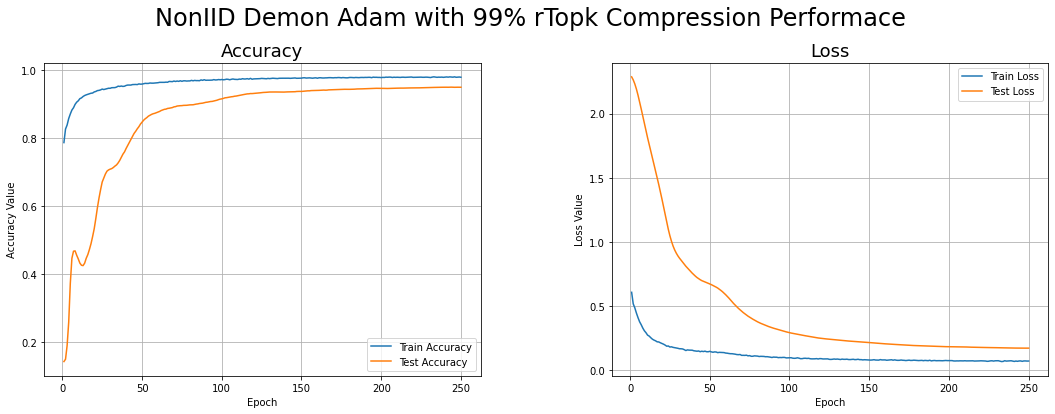

In [ ]:
f = plot(epochs, "NonIID Demon Adam with 99% rTopk Compression Performace", noniid_demon_adam_rtopk_history)

In [ ]:
save(noniid_demon_adam_rtopk_history, server_model, f, "NonIID_Demon_Adam_rTopk")

In [ ]:
client_models, client_optimizers = make_clients(n)
server_model = MnistNet()
server_opt = 'sgd'
server_lr = 0.1
compression = 'rTopk'
sparsity = 0.99
warmup = 5

In [ ]:
noniid_sgd_rtopk_history = fit_federated(epochs, client_models, client_optimizers, noniid_dls, 
                  server_model, server_opt, server_lr, test_dl, criterion,
                  compression = compression , sparsity = sparsity , warmup = warmup)

Epoch 1 - train_loss : 0.5863, train_acc : 0.7930, test_loss : 2.3125, test_acc : 0.1119
Epoch 2 - train_loss : 0.5189, train_acc : 0.8258, test_loss : 2.2879, test_acc : 0.1422
Epoch 3 - train_loss : 0.4766, train_acc : 0.8432, test_loss : 2.2325, test_acc : 0.2768
Epoch 4 - train_loss : 0.4243, train_acc : 0.8614, test_loss : 2.1346, test_acc : 0.3372
Epoch 5 - train_loss : 0.3625, train_acc : 0.8863, test_loss : 2.0073, test_acc : 0.4456
Epoch 6 - train_loss : 0.3136, train_acc : 0.9031, test_loss : 1.8586, test_acc : 0.4617
Epoch 7 - train_loss : 0.2760, train_acc : 0.9148, test_loss : 1.6572, test_acc : 0.4840
Epoch 8 - train_loss : 0.2494, train_acc : 0.9227, test_loss : 1.4533, test_acc : 0.5017
Epoch 9 - train_loss : 0.2306, train_acc : 0.9290, test_loss : 1.1485, test_acc : 0.6720
Epoch 10 - train_loss : 0.2068, train_acc : 0.9368, test_loss : 1.0142, test_acc : 0.6792
Epoch 11 - train_loss : 0.1989, train_acc : 0.9406, test_loss : 0.9241, test_acc : 0.7093
Epoch 12 - train_lo

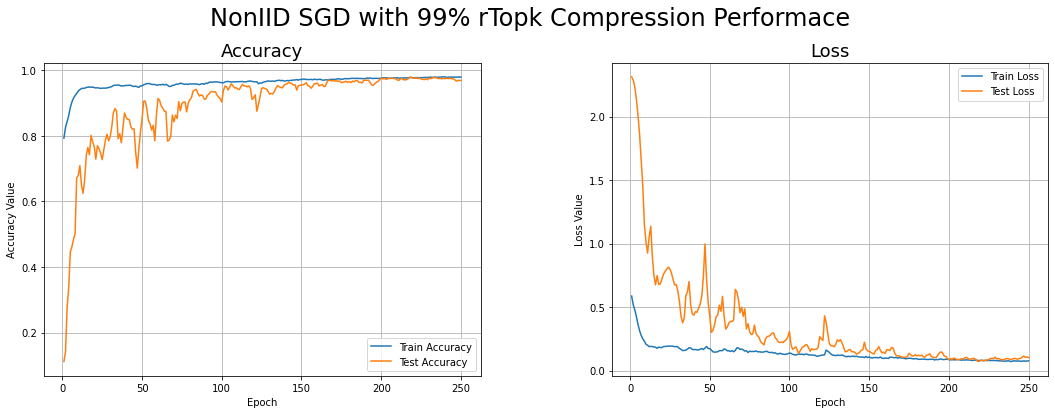

In [ ]:
f = plot(epochs, "NonIID SGD with 99% rTopk Compression Performace", noniid_sgd_rtopk_history)

In [ ]:
save(noniid_sgd_rtopk_history, server_model, f, "NonIID_SGD_rTopk")